In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import SimpleSensor
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

def _clean_regression_inputs(ar1, ar2):
    ar1 = ar1.stack(pix=['x','y'])
    ar2 = ar2.stack(pix=['x','y'])
    ar1 = ar1.where(~ar2.isnull())
    ar2 = ar2.where(~ar1.isnull())
    X = np.atleast_2d(ar1.dropna(dim='pix').values)
    y = ar2.dropna(dim='pix').values
    return X.T, y

def RMSE(x0, x1):
    return np.sqrt(np.sum((x0.ravel() - x1.ravel())**2)/len(x0))

def calibrate_and_score(simulation, reference,
                        index=NDVI,
                        calibration=linear_model.RANSACRegressor,
                        scorer=RMSE):
    out = {}
    # spatial interpolate simulation (NN) like input
    sim = simulation.interp(x=reference.x, y=reference.y, method='nearest')
    s, r = _clean_regression_inputs(index(sim), index(reference))
    m = calibration()
    m.fit(s, r)
    s_adj = m.predict(s)
    out['simulation'] = s.ravel()
    out['calibrated_simulation'] = s_adj
    out['reference'] = r
    out['score'] = scorer(s, r)
    out['calibrated_score'] = scorer(s_adj, r)
    out['calibration'] = m
    return out

def plot_linear_calibration(calibration_dict, ax):
    # generate calibration lines
    _min = calibration_dict['reference'].min()
    _max = calibration_dict['reference'].max()
    _m = calibration_dict['calibration'].estimator_.coef_
    _c = calibration_dict['calibration'].estimator_.intercept_
    x = np.linspace(_min, _max, 100)
    y_0 = x
    y_1 = (x - _c) / _m
    ax.scatter(calibration_dict['reference'],
               calibration_dict['simulation'],
               s=.1, c='r', alpha=.1)
    ax.scatter(calibration_dict['reference'],
               calibration_dict['calibrated_simulation'],
               s=.1, c='k', alpha=.1)
    ax.plot(x, y_0, 'k--')
    ax.plot(x, y_1, 'r--')
    ax.set_xlabel('Reference NDVI')
    ax.set_ylabel('Simulated NDVI')
    ax.set_title('RMSE: {:.2f}, cRMSE: {:.2f}'.format(
    calibration_dict['score'], calibration_dict['calibrated_score']))
    
def dark_noise_experiment(dark_noise, TOA, TOA_ref, reference, sensor, repeats=1):
    out = []
    for r in range(repeats):
        for dark in dark_noise:
            sensor.dark_noise = dark
            reflectance = sensor.fit_transform(TOA)/sensor.fit_transform(TOA_ref).mean(['x', 'y'])
            _re = calibrate_and_score(reflectance, reference)
            _re['dark_noise'] = dark
            _re['rep'] = r
            out.append(_re)
    return out

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000
im_ref = im_ref.where(im_ref <= 1, 1)

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(TOA))

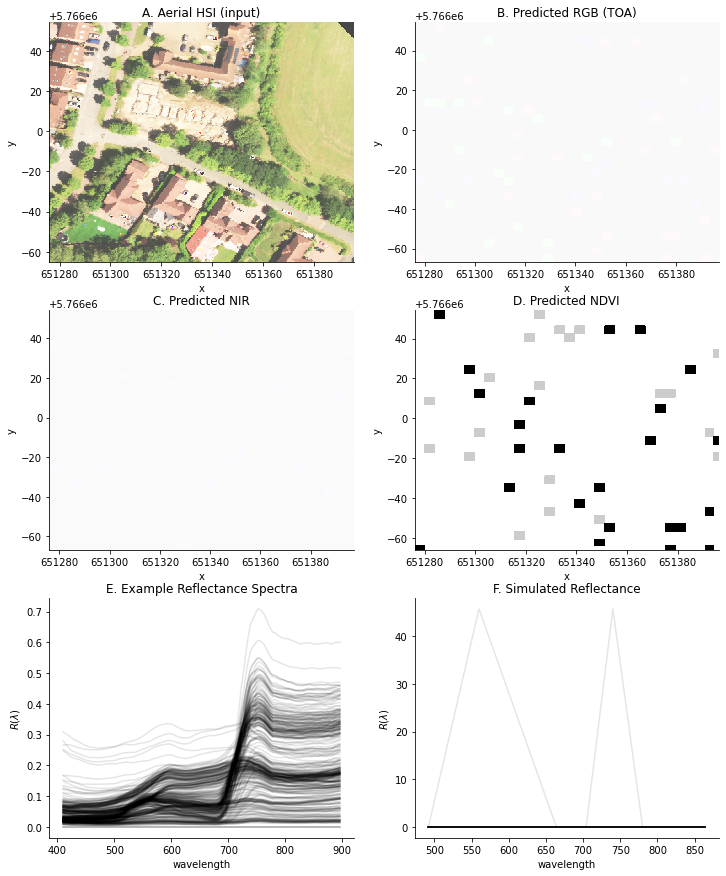

In [4]:
ccd = SimpleSensor(integration_time=.1,
                 sense_node_gain=5,
                 dark_noise=10,
                 adc_gain=5000,
                 adc_vref=5,
                 full_well=100000,
                 store_steps=False,
                 ccd_vref=5,
                 psf_fwhm=8,
                 pixel_area = 10,
                 ground_sample_distance=4)
# write latex table of parameters
ccd.steps_to_latex('outputs/im1.tex')
# generate reference and signal arrays

sig = ccd.transform(TOA)
out_r = sig/ccd.fit_transform(TOA_ref).mean(['x','y'])
sensor_wlen = list(ccd.spectral_response.band_wavelengths.values())
out_rp = out_r.assign_coords(
    wavelength = ('band', sensor_wlen)
).swap_dims({'band': 'wavelength'})

rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = sig.isel(band=[2,1,0])
nir = out_r.isel(band=[6,1,0])
ndvi = ((out_r.isel(band=6) - out_r.isel(band=2))/(out_r.isel(band=6) + out_r.isel(band=2)))

fig, ax = plt.subplots(3,2, figsize=(12,15))

rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB (TOA)')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, robust=True, vmin=0, cmap='nipy_spectral')
ax[1][1].set_title('D. Predicted NDVI')

im_ref.isel(y=20).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][0])
ax[2][0].set_title('E. Example Reflectance Spectra')
ax[2][0].set_ylabel(r'$R(\lambda)$')

out_rp.isel(y=4).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][1])
ax[2][1].set_title('F. Simulated Reflectance')
ax[2][1].set_ylabel(r'$R(\lambda)$')
sns.despine()

plt.savefig('outputs/test_output_im1.png', dpi=200)

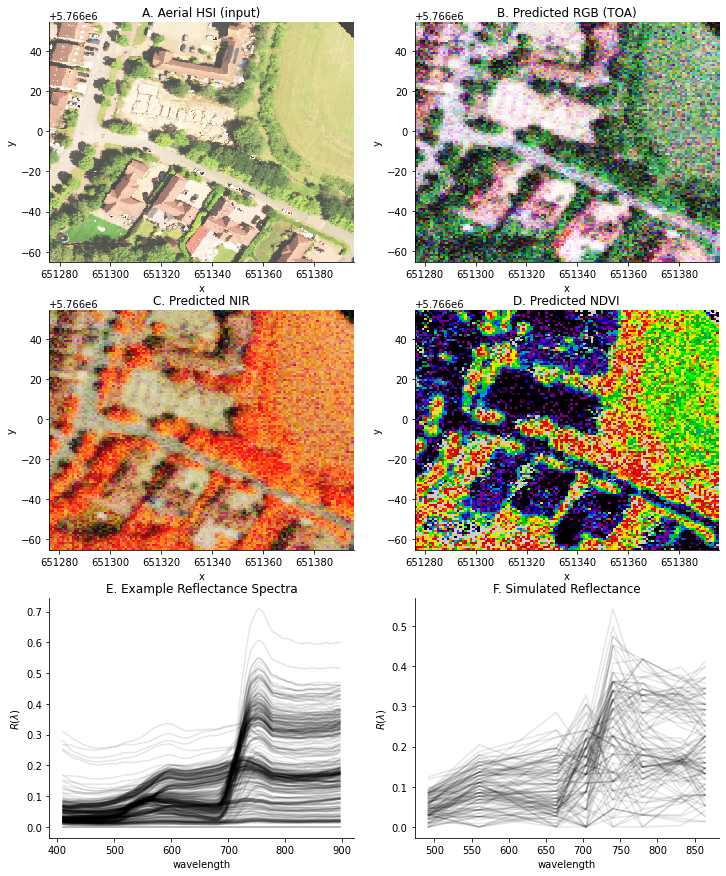

In [6]:
ccd = SimpleSensor(integration_time=.1,
                 sense_node_gain=5,
                 dark_noise=120,
                 adc_gain=5000,
                 adc_vref=5,
                 full_well=100000,
                 store_steps=True,
                 ccd_vref=5,
                 psf_fwhm=2,
                 pixel_area = 5,
                 ground_sample_distance=1)
# write latex table of parameters
ccd.steps_to_latex('outputs/im2.tex')
# generate reference and signal arrays
reference = atmos.transform(xarray.ones_like(TOA))
sig = ccd.transform(TOA)

out_r = sig/ccd.fit_transform(TOA_ref).mean(['x','y'])
sensor_wlen = list(ccd.spectral_response.band_wavelengths.values())
out_rp = out_r.assign_coords(
    wavelength = ('band', sensor_wlen)
).swap_dims({'band': 'wavelength'})

rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = sig.isel(band=[2,1,0])
nir = out_r.isel(band=[6,1,0])
ndvi = ((out_r.isel(band=6) - out_r.isel(band=2))/(out_r.isel(band=6) + out_r.isel(band=2)))

fig, ax = plt.subplots(3,2, figsize=(12,15))

rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('A. Aerial HSI (input)')

rgb(bgr,ax=ax[0][1])
ax[0][1].set_title('B. Predicted RGB (TOA)')

rgb(nir,ax=ax[1][0])
ax[1][0].set_title('C. Predicted NIR')

ndvi.plot(ax=ax[1][1], add_colorbar=False, robust=True, vmin=0, cmap='nipy_spectral')
ax[1][1].set_title('D. Predicted NDVI')

im_ref.isel(y=20).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][0])
ax[2][0].set_title('E. Example Reflectance Spectra')
ax[2][0].set_ylabel(r'$R(\lambda)$')

out_rp.isel(y=4).plot(hue='x', c='k', alpha=.1, add_legend=False, ax=ax[2][1])
ax[2][1].set_title('F. Simulated Reflectance')
ax[2][1].set_ylabel(r'$R(\lambda)$')
sns.despine()

plt.savefig('outputs/test_output_im2.png', dpi=200)

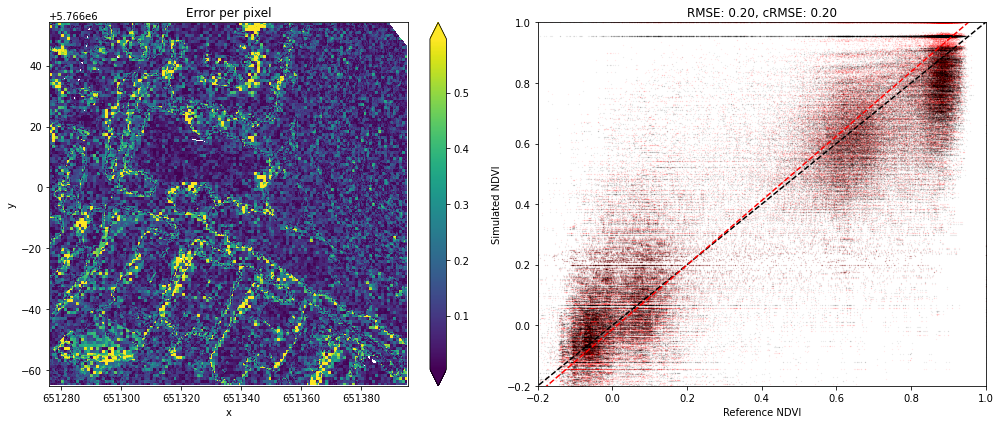

In [7]:
out_interp = out_r.interp(x=im_ref.x, y=im_ref.y, method='nearest')
ndvi_ref = NDVI(im_ref, min_val=-.2)
ndvi_sim = NDVI(out_interp)
exp1 = calibrate_and_score(out_r, im_ref)

f, ax = plt.subplots(ncols=2, figsize=(14,6))
(np.sqrt((ndvi_ref - ndvi_sim)**2)).plot(robust=True, ax=ax[0])
ax[0].set_title('Error per pixel')
plot_linear_calibration(exp1,ax[1])
ax[1].set_xlabel('Reference NDVI')
ax[1].set_ylabel('Simulated NDVI')
ax[1].set_xlim(-.2,1)
ax[1].set_ylim(-.2,1)
plt.tight_layout()

plt.savefig('outputs/test_output_calib.png', dpi=200)

In [9]:
dark_noise_res = dark_noise_experiment(np.linspace(0,120,12), TOA, TOA_ref, im_ref, ccd, 3)
ccd.ground_sample_distance = 5
ccd.psf_fwhm = 10
dark_noise_res2 = dark_noise_experiment(np.linspace(0,120,12), TOA, TOA_ref, im_ref, ccd, 3)

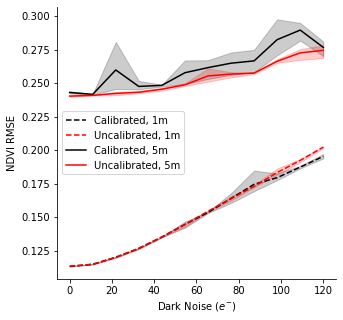

In [10]:
plt.figure(figsize=(5,5))
sns.lineplot(data=pandas.DataFrame(dark_noise_res),
             x='dark_noise', y='calibrated_score', ls='--', label = 'Calibrated, 1m', color='k')
sns.lineplot(data=pandas.DataFrame(dark_noise_res),
             x='dark_noise', y='score',ls='--', label='Uncalibrated, 1m', color='r')

sns.lineplot(data=pandas.DataFrame(dark_noise_res2),
             x='dark_noise', y='calibrated_score', label = 'Calibrated, 5m', color='k')
sns.lineplot(data=pandas.DataFrame(dark_noise_res2),
             x='dark_noise', y='score', label='Uncalibrated, 5m', color='r')
plt.xlabel(r'Dark Noise ($e^{-}$)')
plt.ylabel('NDVI RMSE')
sns.despine()
plt.savefig('outputs/test_output_dn.png', dpi=200)

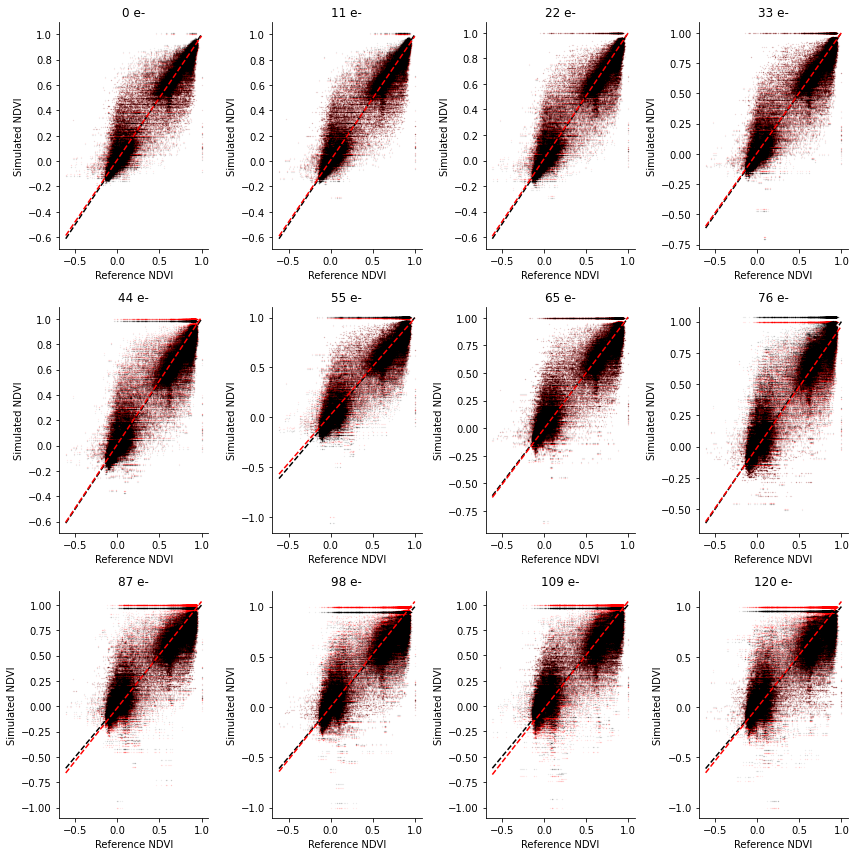

In [11]:
fig, ax = plt.subplots(nrows=3,ncols=4, figsize=(12,12))
ax=np.ravel(ax)
for i, res in enumerate(dark_noise_res):
    plot_linear_calibration(res, ax[i])
    ax[i].set_title('{:.0f} e-'.format(res['dark_noise']))
    if i == 11:
        break
plt.tight_layout()
plt.savefig('outputs/test_output_calibration.png', dpi=200)
sns.despine()